In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
data_path_csv = "data/mq_variants_intensity_cleaned.csv"
df = pd.read_csv(data_path_csv)

In [3]:
df.head()

,Variant,Variant ID,Unmod variant,Total,Total- Unmodified sequence,Variants- Unmodified sequence,Proteins,Mass,Charge,Num Mods,...,_dyn_#Baricitinib 1000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 100nM.Tech replicate 1 of 1,_dyn_#Baricitinib 10nM.Tech replicate 1 of 1,_dyn_#Baricitinib 30000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 3000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 300nM.Tech replicate 1 of 1,_dyn_#Baricitinib 30nM.Tech replicate 1 of 1,_dyn_#Baricitinib 3nM.Tech replicate 1 of 1,_dyn_#Baricitinib DMSO.Tech replicate 1 of 1,_dyn_#Baricitinib PDPD.Tech replicate 1 of 1
0,.VADPDHDHTGFLTEYVATR.,93378,.VADPDHDHTGFLTEYVATR.,11372,15019,62,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,2144.0,2,0,...,0.306845,1.910381,1.514374,0.427875,0.373358,0.811047,1.314729,1.210692,1.130700,70792000.0
1,.LGEHNIDVLEGNEQFINAAK.,50733,.LGEHNIDVLEGNEQFINAAK.,8878,23098,134,TRYP_PIG,2211.1,2,0,...,0.497528,1.517810,1.550758,0.569489,0.418558,0.702659,1.441483,0.862069,1.439645,204790000.0
2,.FRHENIIGINDIIR.,25741,.FRHENIIGINDIIR.,8720,12619,33,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,1709.9,2,0,...,0.416586,1.193311,1.919347,0.515180,0.641698,0.655356,1.271673,1.040796,1.346053,97725000.0
3,.ESESTAGSFSLSVR.,21292,.ESESTAGSFSLSVR.,7995,8328,7,sp|P06239-2|LCK_HUMAN;sp|P06239-3|LCK_HUMAN;sp...,1456.7,2,0,...,0.781283,1.058175,1.283215,0.940069,1.003302,1.350383,0.788028,0.893768,0.901778,8137600.0
4,.NYLLSLPHK.,68115,.NYLLSLPHK.,7445,11842,41,sp|P28482|MK01_HUMAN,1084.6,2,0,...,0.687753,1.429355,1.755752,0.742850,0.893974,0.864243,1.417682,1.078603,0.129789,182850000.0


In [4]:
print(f"There are {len(df)} unique peptide variants in the dataset.")

There are 50659 unique peptide variants in the dataset.


In [5]:
TARGET_PROTEIN = "P28482"
TARGET_DRUG = "AZD-5438"

## Filter rows for target protein

In [6]:
peptide_df = df[df["Proteins"].str.contains(TARGET_PROTEIN)]
print(f"Found {len(peptide_df)} peptides associated with protein {TARGET_PROTEIN}.")

Found 363 peptides associated with protein P28482.


In [7]:
peptide_df.head()

,Variant,Variant ID,Unmod variant,Total,Total- Unmodified sequence,Variants- Unmodified sequence,Proteins,Mass,Charge,Num Mods,...,_dyn_#Baricitinib 1000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 100nM.Tech replicate 1 of 1,_dyn_#Baricitinib 10nM.Tech replicate 1 of 1,_dyn_#Baricitinib 30000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 3000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 300nM.Tech replicate 1 of 1,_dyn_#Baricitinib 30nM.Tech replicate 1 of 1,_dyn_#Baricitinib 3nM.Tech replicate 1 of 1,_dyn_#Baricitinib DMSO.Tech replicate 1 of 1,_dyn_#Baricitinib PDPD.Tech replicate 1 of 1
0,.VADPDHDHTGFLTEYVATR.,93378,.VADPDHDHTGFLTEYVATR.,11372,15019,62,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,2144.0,2,0,...,0.306845,1.910381,1.514374,0.427875,0.373358,0.811047,1.314729,1.210692,1.130700,70792000.0
2,.FRHENIIGINDIIR.,25741,.FRHENIIGINDIIR.,8720,12619,33,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,1709.9,2,0,...,0.416586,1.193311,1.919347,0.515180,0.641698,0.655356,1.271673,1.040796,1.346053,97725000.0
4,.NYLLSLPHK.,68115,.NYLLSLPHK.,7445,11842,41,sp|P28482|MK01_HUMAN,1084.6,2,0,...,0.687753,1.429355,1.755752,0.742850,0.893974,0.864243,1.417682,1.078603,0.129789,182850000.0
13,.YIHSANVLHR.,103102,.YIHSANVLHR.,4635,6206,21,sp|P27361-2|MK03_HUMAN;sp|P27361-3|MK03_HUMAN;...,1209.6,3,0,...,0.712864,1.327237,1.578754,0.750244,0.716364,0.752643,1.092488,1.099883,0.969524,54200000.0
15,.LKELIFEETAR.,52669,.LKELIFEETAR.,4394,9704,26,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,1348.7,2,0,...,NaN,1.531711,0.161650,NaN,NaN,NaN,1.382552,0.040599,1.883488,NaN


## Filter columns for target drug

In [8]:
all_cols = peptide_df.columns.to_series()

mask_base = (
    all_cols.str.contains("_dyn_")
    & all_cols.str.contains(TARGET_DRUG)
    & ~all_cols.str.contains("unmod")
)

ctrl_mask = mask_base & all_cols.str.contains("DMSO.Tech replicate")
treat_mask = mask_base & all_cols.str.contains("nM.Tech replicate")

control_cols = all_cols[ctrl_mask].index
treatment_cols = all_cols[treat_mask].index

print(f"Control (DMSO) columns: {list(control_cols)}")
print(f"Treatment columns: {list(treatment_cols)}")

dose_pat = re.compile(rf"{TARGET_DRUG} ([^\.]+)")
doses = sorted({m.group(1) for col in treatment_cols if (m := dose_pat.search(col))})
print("Doses found:", doses)

Control (DMSO) columns: ['_dyn_#AZD-5438 DMSO.Tech replicate 1 of 1']
Treatment columns: ['_dyn_#AZD-5438 1000nM.Tech replicate 1 of 1', '_dyn_#AZD-5438 100nM.Tech replicate 1 of 1', '_dyn_#AZD-5438 10nM.Tech replicate 1 of 1', '_dyn_#AZD-5438 30000nM.Tech replicate 1 of 1', '_dyn_#AZD-5438 3000nM.Tech replicate 1 of 1', '_dyn_#AZD-5438 300nM.Tech replicate 1 of 1', '_dyn_#AZD-5438 30nM.Tech replicate 1 of 1', '_dyn_#AZD-5438 3nM.Tech replicate 1 of 1']
Doses found: ['1000nM', '100nM', '10nM', '30000nM', '3000nM', '300nM', '30nM', '3nM']


## Build control and treatment distributions

In [9]:
def get_log_intensities(df: pd.DataFrame, cols: pd.Index) -> np.ndarray:
    return (
        df[cols]
        .apply(pd.to_numeric)  # Convert to numeric
        .stack()  # drop NaN values
        .pipe(np.log)  # log transform
        .values  # convert to numpy array
    )


control_log = get_log_intensities(peptide_df, control_cols)
dose_log = {
    dose: get_log_intensities(
        peptide_df,
        treatment_cols[treatment_cols.str.contains(f"{TARGET_DRUG} {dose}")],
    )
    for dose in doses
}

print(f"Control (n={len(control_log)})")
for dose, log_intensities in dose_log.items():
    print(f"{dose} (n={len(log_intensities)})")

Control (n=27)
1000nM (n=29)
100nM (n=9)
10nM (n=26)
30000nM (n=29)
3000nM (n=32)
300nM (n=34)
30nM (n=10)
3nM (n=12)


## t-test

In [10]:
def run_t_test(control: np.ndarray, dose_logs: dict):
    rows = []
    threshold = 0.05
    for dose, vals in dose_logs.items():
        t_stat, p_val = stats.ttest_ind(
            vals,
            control,
            equal_var=False,
            nan_policy="raise",
            alternative="less",
        )
        rows.append(
            {
                "dose": dose,
                "t_statistic": t_stat,
                "p_value": p_val,
            }
        )
    df = (
        pd.DataFrame(rows)
        .sort_values("p_value")
        .assign(significant=lambda d: d["p_value"] < threshold)
    )
    return df


results_df = run_t_test(control_log, dose_log)
print(results_df.to_string(index=False))

if not results_df["significant"].any():
    best = results_df.iloc[0]
    print(f"No significant results; using {best.dose} (p={best.p_value:.4g})")
    significant_df = best.to_frame().T
else:
    significant_df = results_df[results_df["significant"]]

significant_doses = significant_df["dose"].tolist()

   dose  t_statistic      p_value  significant
    3nM   -18.066065 2.061250e-17         True
   30nM   -16.741054 1.086670e-15         True
  100nM   -15.774506 3.363333e-13         True
   10nM    -5.996932 1.038995e-07         True
  300nM     1.247064 8.900741e-01        False
 1000nM     1.561092 9.368311e-01        False
30000nM     3.555808 9.995884e-01        False
 3000nM     5.723857 9.999991e-01        False


## ANOVA

In [11]:
groups = [control_log] + list(dose_log.values())
print(len(groups), "groups")
f_stat, p_val = stats.f_oneway(*groups)
print(f"One‐way ANOVA: F = {f_stat:.3f}, p = {p_val:.3g}")

9 groups
One‐way ANOVA: F = 187.488, p = 2.6e-88


## Visualization

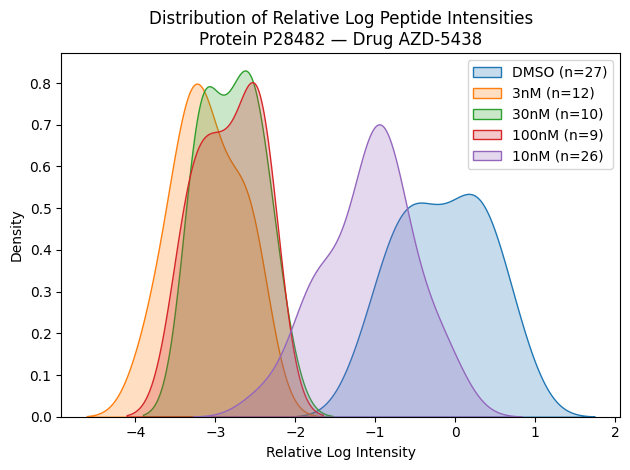

In [12]:
sns.kdeplot(
    control_log,
    fill=True,
    label=f"DMSO (n={len(control_log)})",
)

for dose in significant_doses:
    arr = dose_log[dose]
    sns.kdeplot(arr, fill=True, label=f"{dose} (n={len(arr)})")

plt.legend()
plt.xlabel("Relative Log Intensity")
plt.title(
    "Distribution of Relative Log Peptide Intensities\n"
    f"Protein {TARGET_PROTEIN} — Drug {TARGET_DRUG}"
)
plt.tight_layout()